### Entailment Model

In [1]:
import torch
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
import wandb 
import csv
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# from transformers import DistilBertTokenizer
import numpy as np
import torch.nn as nn
# import torch.optim as optim
# from tabulate import tabulate
# from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch

In [2]:
from utils import ContractNLIDataset, ContractNLIDatasetTest

In [3]:
ENTAILMENT = 0
CONTRADICTION = 1
NOT_MENTIONED = 2

In [32]:
csv_folder = "../dataset/csv/all_labels"

train_df = pd.read_csv(f'{csv_folder}/train.csv')
val_df = pd.read_csv(f'{csv_folder}/validation.csv')
test_df = pd.read_csv(f'{csv_folder}/test.csv')

In [33]:
# Convery all the NON-MENTIONED to CONTRADICTION
train_df['label'] = train_df['label'].replace(1, 2)
val_df['label'] = val_df['label'].replace(1, 2)
test_df['label'] = test_df['label'].replace(1, 2)

train_df['label'] = train_df['label'].replace(0, 1)
val_df['label'] = val_df['label'].replace(0, 1)
test_df['label'] = test_df['label'].replace(0, 1)

train_df['label'] = train_df['label'].replace(2, 0)
val_df['label'] = val_df['label'].replace(2, 0)
test_df['label'] = test_df['label'].replace(2, 0)

In [34]:
n_sample = 1500

not_entailment_df = train_df[train_df['label'] == 0]
entailment_df = train_df[train_df['label'] == 1].sample(n_sample, random_state=42)

train_df = pd.concat([not_entailment_df, entailment_df]).reset_index(drop=True)

<Axes: xlabel='label'>

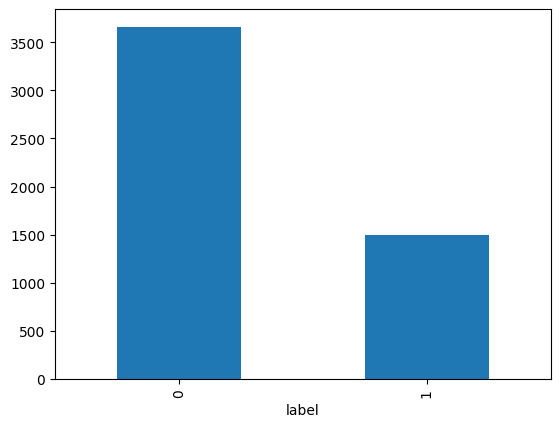

In [35]:
train_df['label'].value_counts().plot(kind='bar')

In [36]:
print(train_df['concatenated_spans'].str.len().describe())
print(val_df['concatenated_spans'].str.len().describe())
print(test_df['concatenated_spans'].str.len().describe())

count    5161.000000
mean      443.956210
std       302.395531
min         5.000000
25%       239.000000
50%       378.000000
75%       569.000000
max      3116.000000
Name: concatenated_spans, dtype: float64
count    1037.000000
mean      495.812922
std       337.028784
min        20.000000
25%       261.000000
50%       414.000000
75%       613.000000
max      2920.000000
Name: concatenated_spans, dtype: float64
count    2091.000000
mean      445.876614
std       318.588350
min         5.000000
25%       230.000000
50%       364.000000
75%       564.000000
max      2492.000000
Name: concatenated_spans, dtype: float64


In [14]:
model_name = "FacebookAI/roberta-base"

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# check context len
# model_name2.config.max_position_embeddings
max_length = tokenizer.model_max_length
print(max_length)

512


In [16]:
train_labels = train_df['label']
valid_labels = val_df['label']
test_labels = test_df['label']

In [17]:
def tokenize_data(data):
    return tokenizer(text=data['concatenated_spans'].tolist(), text_pair=data['hypothesis'].tolist(), truncation=True, padding="max_length", max_length=max_length)

In [20]:
train_encodings = tokenize_data(train_df)
valid_encodings = tokenize_data(val_df)
test_encodings = tokenize_data(test_df)

train_dataset = ContractNLIDataset(train_encodings, train_labels)
valid_dataset = ContractNLIDataset(valid_encodings, valid_labels)
test_dataset = ContractNLIDatasetTest(test_encodings)

In [ ]:
def metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    accuracy = accuracy_score(p.label_ids, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        p.label_ids, preds, average="macro"
    )
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [24]:
with open("../t.txt", 'a+') as f:
    f.write("Starting training\n")

In [ ]:
model_name = "roberta_base"

wandb.init(project="contract-nli", tags=["entailment", model_name])

model_name = "roberta_base"

training_args = TrainingArguments(
    output_dir=f'./{model_name}_entailment',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    # logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    report_to="wandb",
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=metrics,
)

# Train the model
train_results = trainer.train()

# Evaluate the model on the validation dataset
eval_results = trainer.evaluate()

print("Training complete.")

trainer.save_model(f'./{model_name}_entailment')  # Save the model to the specified output directory

In [ ]:
# Use the Trainer.predict() method to get predictions
predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(axis=1)


confusion_mat = confusion_matrix(test_labels, pred_labels)
print("Confusion Matrix:")
print(confusion_mat)


class_names = ["ENTAILMENT", "NON-ENTAILMENT"]
print("\nClassification Report:")
print(classification_report(test_labels, pred_labels, target_names=class_names))

# Error analysis

incorrect_predictions = []
for i in range(len(test_labels)):
    if test_labels[i] != pred_labels[i]:
        incorrect_predictions.append(i)

print(
    f"Number of incorrect predictions: {len(incorrect_predictions)} out of {len(test_labels)}")

In [ ]:
wandb.finish()